## Ionization bubbles: test on a uniform box

Generate input layer of halo properties (initially just positions, later include mass), output layer of ionization field (volume occupied by ionized bubbles)

Box size $L_{box}\, = 80 h^{-1}$ comoving Mpc

Test grid setup: N=16 cells, cell size 5 $h^{-1}$ comoving Mpc

Assumed bubble radius 2 cells, or 10 $h^{-1}$ comoving Mpc

Number of halos = 32

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')

import tensorflow as tf
from tensorflow import keras

rng = np.random.default_rng(1)

### Preliminary tests of input/output setup

In [40]:
N = 3
Rbubble = 1
Nhalos = 5

halos = np.zeros((N,N,N))
halo_xyz = np.zeros((Nhalos,3))

for nh in range(Nhalos):
    i = rng.integers(low=0, high=N, size=3)
    halo_xyz[nh] = i
    halos[i[0], i[1], i[2]] = 1

print(halos)

ionization_field = np.zeros((N,N,N))

for ix in range(N):
    for iy in range(N):
        for iz in range(N):
            for nh in range(Nhalos):
                dr2 = (ix-halo_xyz[nh][0])**2 + (iy-halo_xyz[nh][1])**2 + (iz-halo_xyz[nh][2])**2
                if dr2 < Rbubble**2:
                    ionization_field[ix,iy,iz] = 1

print(ionization_field)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [1. 0. 1.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [1. 0. 1.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]]]


In [63]:
ionization_fieldv = np.zeros((N,N,N))

xx, yy, zz, hh = np.meshgrid(range(N),range(N),range(N),range(Nhalos), indexing='ij', sparse=True)
dr2 = (xx - halo_xyz[:,0])**2 + (yy - halo_xyz[:,1])**2 + (zz - halo_xyz[:,2])**2
idx = np.where(dr2 < Rbubble**2)
ionization_fieldv[idx[:3]] = 1

print(ionization_fieldv)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [1. 0. 1.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]]]


In [64]:
ionization_fieldv = np.zeros((N,N,N))

xx, yy, zz = np.meshgrid(range(N), range(N), range(N), indexing='ij', sparse=True)
for nh in range(Nhalos):
    dr2 = (xx-halo_xyz[nh][0])**2 + (yy-halo_xyz[nh][1])**2 + (zz-halo_xyz[nh][2])**2
    ionization_fieldv[dr2 < Rbubble**2] = 1

print(ionization_fieldv)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [1. 0. 1.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]]]


### Generation of input and output, and timing

In [81]:
def GenerateRandomBox( Lbox = 80., N = 16, Rbubble = 4., Nhalos = 32 ):
    # Lbox = box size in h^{-1} Mpc
    # N = grid size
    # Rbubble = radius of ionized bubble in h^{-1} Mpc
    
    # generate 3D array of halo positions
    halos = np.zeros((N,N,N))
    halo_xyz = np.zeros((Nhalos,3))

    for nh in range(Nhalos):
        i = rng.integers(low=0, high=N, size=3)
        halo_xyz[nh] = i
        halos[i[0], i[1], i[2]] = 1

    # generate ionization bubbles
    ionization_field = np.zeros((N,N,N))

    for ix in range(N):
        for iy in range(N):
            for iz in range(N):
                for nh in range(Nhalos):
                    dr2 = (ix-halo_xyz[nh][0])**2 + (iy-halo_xyz[nh][1])**2 + (iz-halo_xyz[nh][2])**2
                    if dr2 < Rbubble**2:
                        ionization_field[ix,iy,iz] = 1
    
    return halos, ionization_field


# Vectorized version

def GenerateRandomBoxV( Lbox = 80., N = 16, Rbubble = 4., Nhalos = 32 ):
    # Lbox = box size in h^{-1} Mpc
    # N = grid size
    # Rbubble = radius of ionized bubble in h^{-1} Mpc
    
    # generate 3D array of halo positions
    halos = np.zeros((N,N,N))
    halo_xyz = np.zeros((Nhalos,3))

    for nh in range(Nhalos):
        i = rng.integers(low=0, high=N, size=3)
        halo_xyz[nh] = i
        halos[i[0], i[1], i[2]] = 1

    # generate ionization bubbles
    ionization_field = np.zeros((N,N,N))
    
    xx, yy, zz, hh = np.meshgrid(range(N),range(N),range(N),range(Nhalos), indexing='ij', sparse=True)
    dr2 = (xx - halo_xyz[:,0])**2 + (yy - halo_xyz[:,1])**2 + (zz - halo_xyz[:,2])**2
    idx = np.where(dr2 < Rbubble**2)
    ionization_field[idx[:3]] = 1
    
    return halos, ionization_field


# version Z

def GenerateRandomBoxZ( Lbox = 80., N = 16, Rbubble = 4., Nhalos = 32 ):
    # Lbox = box size in h^{-1} Mpc
    # N = grid size
    # Rbubble = radius of ionized bubble in h^{-1} Mpc
    
    # generate 3D array of halo positions
    halos = np.zeros((N,N,N))
    halo_xyz = np.zeros((Nhalos,3))

    for nh in range(Nhalos):
        i = rng.integers(low=0, high=N, size=3)
        halo_xyz[nh] = i
        halos[i[0], i[1], i[2]] = 1

    # generate ionization bubbles
    ionization_field = np.zeros((N,N,N))
    
    xx, yy, zz = np.meshgrid(range(N), range(N), range(N), indexing='ij', sparse=True)
    for nh in range(Nhalos):
        dr2 = (xx-halo_xyz[nh][0])**2 + (yy-halo_xyz[nh][1])**2 + (zz-halo_xyz[nh][2])**2
        ionization_field[dr2 < Rbubble**2] = 1
    
    return halos, ionization_field

In [59]:
%timeit -n 100 GenerateRandomBox( Lbox = 80., N = 16, Rbubble = 2, Nhalos = 32 )

%timeit -n 100 GenerateRandomBoxV( Lbox = 80., N = 16, Rbubble = 2, Nhalos = 32 )

%timeit -n 100 GenerateRandomBoxZ( Lbox = 80., N = 16, Rbubble = 2, Nhalos = 32 )

349 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.99 ms ± 86.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.71 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
%timeit -n 100 GenerateRandomBoxV( Lbox = 80., N = 16, Rbubble = 2, Nhalos = 32 )

%timeit -n 100 GenerateRandomBoxZ( Lbox = 80., N = 16, Rbubble = 2, Nhalos = 32 )

1.88 ms ± 40.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.96 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
%timeit -n 100 GenerateRandomBoxV( Lbox = 80., N = 32, Rbubble = 2, Nhalos = 32 )

%timeit -n 100 GenerateRandomBoxZ( Lbox = 80., N = 32, Rbubble = 2, Nhalos = 32 )

9.88 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.86 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Actual model setup and calculation

In [82]:
n_train = 10000
n_test = n_train//5
N = 16

x_train = np.ndarray((n_train, N, N, N)).astype(np.float32)
y_train = np.ndarray((n_train, N, N, N)).astype(np.float32)

x_test = np.ndarray((n_test, N, N, N)).astype(np.float32)
y_test = np.ndarray((n_test, N, N, N)).astype(np.float32)

for n in range(n_train):
    x_train[n], y_train[n] = GenerateRandomBoxZ( Lbox = 80., N = N, Rbubble = 2., Nhalos = 32 )
    
for n in range(n_test):
    x_test[n], y_test[n] = GenerateRandomBoxZ( Lbox = 80., N = N, Rbubble = 2., Nhalos = 32 )

In [78]:
np.savez('box_io_data.npz', x_train, y_train, x_test, y_test)

In [79]:
npzfile = np.load('box_io_data.npz')
npzfile.files

['arr_0', 'arr_1', 'arr_2', 'arr_3']

In [83]:
# Convert numpy arrays of data to tensorflow dataframes. Not essential but speeds up computational time.
# cache: saves training data to ram in easy-to-access way
# shuffle: shuffles the training set each 'epoch' of training
# batch: sets the minibatch size for training and inference
# prefetch: pre-loads a few minibatches of data from the cache just before inference

batch_size = n_train//10

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(n_train, reshuffle_each_iteration=True).batch(batch_size).prefetch(3)

dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().batch(batch_size).prefetch(3)

In [84]:
# Construct 3D U_NET CNN model

# Specify layers and their interactions
FILTERS = 2 #This parameter tunes the complexity / number of parameters of the model

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
params_final = dict(kernel_size=(1, 1, 1), activation="sigmoid", padding="same")
params = dict(kernel_size=(3, 3, 3), activation="relu", padding="same")
params_maxpool = dict(size=(2, 2, 2))

input_layer = keras.layers.Input(shape=(N, N, N, 1), name="input_layer")

encoder_1_a = keras.layers.Conv3D(FILTERS, name='encoder_1_a', **params)(input_layer)
encoder_1_b = keras.layers.Conv3D(FILTERS, name='encoder_1_b', **params)(encoder_1_a)
downsample_1 = keras.layers.MaxPool3D(name='downsample_1')(encoder_1_b)

encoder_2_a = keras.layers.Conv3D(FILTERS*2, name='encoder_2_a', **params)(downsample_1)
encoder_2_b = keras.layers.Conv3D(FILTERS*2, name='encoder_2_b', **params)(encoder_2_a)
downsample_2 = keras.layers.MaxPool3D(name='downsample_2')(encoder_2_b)

encoder_3_a = keras.layers.Conv3D(FILTERS*4, name='encoder_3_a', **params)(downsample_2)
encoder_3_b = keras.layers.Conv3D(FILTERS*4, name='encoder_3_b', **params)(encoder_3_a)
downsample_3 = keras.layers.MaxPool3D(name='downsample_3')(encoder_3_b)

encoder_4_a = keras.layers.Conv3D(FILTERS*8, name='encoder_4_a', **params)(downsample_3)
encoder_4_b = keras.layers.Conv3D(FILTERS*8, name='encoder_4_b', **params)(encoder_4_a)
#downsample_4 = keras.layers.MaxPool3D(name='downsample_4')(encoder_4_b)

#encoder_5_a = keras.layers.Conv3D(FILTERS*16, name='encoder_5_a', **params)(downsample_4)
#encoder_5_b = keras.layers.Conv3D(FILTERS*16, name='encoder_5_b', **params)(encoder_5_a)

#upsample_4 = keras.layers.UpSampling3D(name='upsample_4', **params_maxpool)(encoder_5_b)
#concat_4 = keras.layers.concatenate([upsample_4, encoder_4_b], name='concat_4')
#decoder_4_a = keras.layers.Conv3D(FILTERS*8, name='decoder_4_a', **params)(concat_4)
#decoder_4_b = keras.layers.Conv3D(FILTERS*8, name='decoder_4_b', **params)(decoder_4_a)

upsample_3 = keras.layers.UpSampling3D(name='upsample_3', **params_maxpool)(encoder_4_b)
concat_3 = keras.layers.concatenate([upsample_3, encoder_3_b], name='concat_3')
decoder_3_a = keras.layers.Conv3D(FILTERS*4, name='decoder_3_a', **params)(concat_3)
decoder_3_b = keras.layers.Conv3D(FILTERS*4, name='decoder_3_b', **params)(decoder_3_a)

upsample_2 = keras.layers.UpSampling3D(name='upsample_2', **params_maxpool)(decoder_3_b)
concat_2 = keras.layers.concatenate([upsample_2, encoder_2_b], name='concat_2')
decoder_2_a = keras.layers.Conv3D(FILTERS*2, name='decoder_2_a', **params)(concat_2)
decoder_2_b = keras.layers.Conv3D(FILTERS*2, name='decoder_2_b', **params)(decoder_2_a)

upsample_1 = keras.layers.UpSampling3D(name='upsample_1', **params_maxpool)(decoder_2_b)
concat_1 = keras.layers.concatenate([upsample_1, encoder_1_b], name='concat_1')
decoder_1_a = keras.layers.Conv3D(FILTERS, name='decoder_1_a', **params)(concat_1)
decoder_1_b = keras.layers.Conv3D(FILTERS, name='decoder_1_b', **params)(decoder_1_a)

output_layer = keras.layers.Conv3D(name="output_layer", filters=1, **params_final)(decoder_1_b)

print('Input size:', input_layer.shape)
print('Output size:', output_layer.shape)

model = keras.models.Model(inputs=input_layer, outputs=output_layer, name='test_cnn_3d')

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
          loss='binary_crossentropy', metrics=['acc'])

Input size: (None, 16, 16, 16, 1)
Output size: (None, 16, 16, 16, 1)


In [85]:
model.summary()

Model: "test_cnn_3d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 16, 16, 16,  0                                            
__________________________________________________________________________________________________
encoder_1_a (Conv3D)            (None, 16, 16, 16, 2 56          input_layer[0][0]                
__________________________________________________________________________________________________
encoder_1_b (Conv3D)            (None, 16, 16, 16, 2 110         encoder_1_a[0][0]                
__________________________________________________________________________________________________
downsample_1 (MaxPooling3D)     (None, 8, 8, 8, 2)   0           encoder_1_b[0][0]                
________________________________________________________________________________________

In [86]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(dataset_train, verbose=1, epochs=20,
                    validation_data=dataset_test, callbacks=early_stopping)

Epoch 1/20
10/10 [==============================] - 54s 5s/step - loss: 0.6671 - acc: 0.8307 - val_loss: 0.5603 - val_acc: 0.8308
Epoch 2/20
10/10 [==============================] - 52s 5s/step - loss: 0.5315 - acc: 0.8307 - val_loss: 0.5166 - val_acc: 0.8308
Epoch 3/20
10/10 [==============================] - 52s 5s/step - loss: 0.5121 - acc: 0.8307 - val_loss: 0.5003 - val_acc: 0.8308
Epoch 4/20
10/10 [==============================] - 52s 5s/step - loss: 0.4973 - acc: 0.8307 - val_loss: 0.4859 - val_acc: 0.8308
Epoch 5/20
10/10 [==============================] - 52s 5s/step - loss: 0.4810 - acc: 0.8307 - val_loss: 0.4736 - val_acc: 0.8308
Epoch 6/20
10/10 [==============================] - 52s 5s/step - loss: 0.4651 - acc: 0.8307 - val_loss: 0.4524 - val_acc: 0.8308
Epoch 7/20
10/10 [==============================] - 52s 5s/step - loss: 0.4440 - acc: 0.8307 - val_loss: 0.4292 - val_acc: 0.8308
Epoch 8/20
10/10 [==============================] - 52s 5s/step - loss: 0.4189 - acc: 0.83

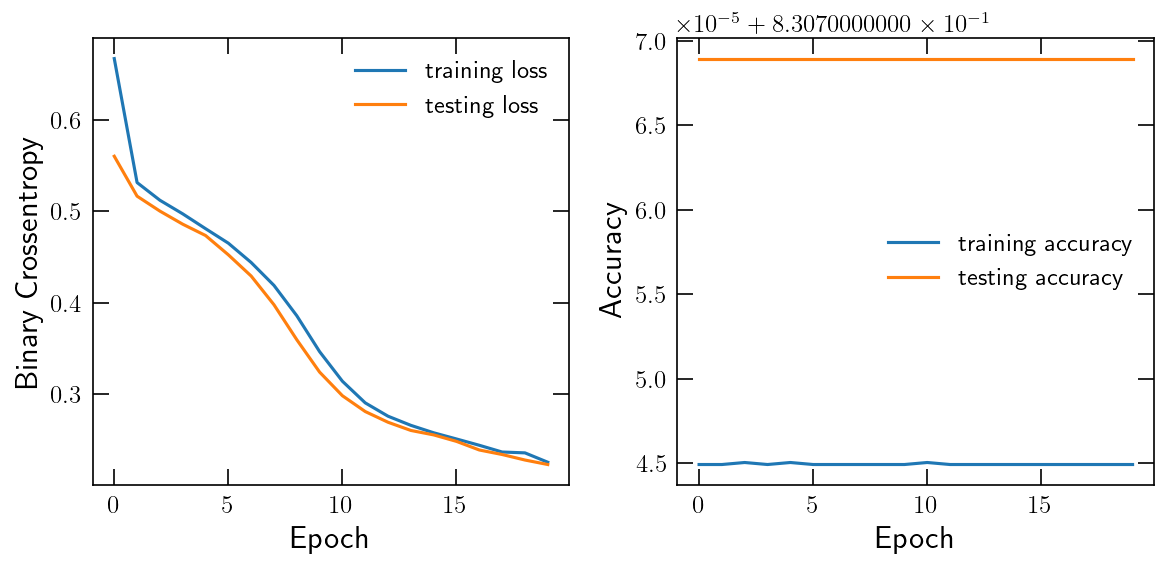

In [87]:
# Plot the loss (objective) and the prediction accuracy metric as a function of epoch

figure = plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='testing loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Binary Crossentropy')
plt.legend()

ax = plt.subplot(1,2,2)
ax.plot(history.history['acc'], label='training accuracy')
ax.plot(history.history['val_acc'], label='testing accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()

plt.tight_layout();

Saved plot for larger grid N=32:

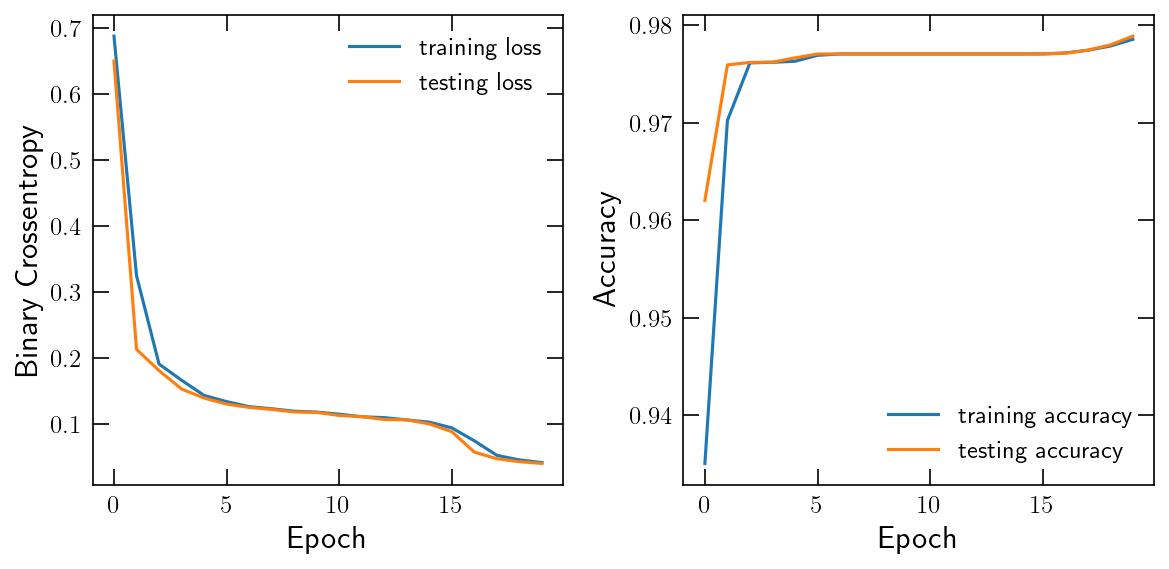

In [77]:
# Plot the loss (objective) and the prediction accuracy metric as a function of epoch

figure = plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='testing loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Binary Crossentropy')
plt.legend()

ax = plt.subplot(1,2,2)
ax.plot(history.history['acc'], label='training accuracy')
ax.plot(history.history['val_acc'], label='testing accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend()

plt.tight_layout();